In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load data with the specified path
file_path = r"/content/green_tripdata_2024-10.parquet"
df = pd.read_parquet(file_path)
print("Dataset overview:")
print(f"Number of records: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(df.info())

Dataset overview:
Number of records: 56147
Number of columns: 20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56147 entries, 0 to 56146
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56147 non-null  int32         
 1   lpep_pickup_datetime   56147 non-null  datetime64[us]
 2   lpep_dropoff_datetime  56147 non-null  datetime64[us]
 3   store_and_fwd_flag     54502 non-null  object        
 4   RatecodeID             54502 non-null  float64       
 5   PULocationID           56147 non-null  int32         
 6   DOLocationID           56147 non-null  int32         
 7   passenger_count        54502 non-null  float64       
 8   trip_distance          56147 non-null  float64       
 9   fare_amount            56147 non-null  float64       
 10  extra                  56147 non-null  float64       
 11  mta_tax                56147 non-null  float64       


In [6]:
# Data preparation
# Drop unused column and calculate trip duration
df = df.drop("ehail_fee", axis=1)
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [7]:
# Extract date features
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
df['dayofmonth'] = df['lpep_dropoff_datetime'].dt.day
df['weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

In [8]:
# Display some basic distributions
print("\nWeekday trip distribution:")
weekday_counts = df['weekday'].value_counts()
print(weekday_counts)


Weekday trip distribution:
weekday
Thursday     9984
Wednesday    9654
Tuesday      9306
Friday       7276
Monday       6969
Saturday     6892
Sunday       6066
Name: count, dtype: int64


In [9]:
print("\nHour of day distribution:")
hour_counts = df['hourofday'].value_counts().sort_index()
print(hour_counts)


Hour of day distribution:
hourofday
0     1175
1      722
2      546
3      416
4      343
5      304
6      662
7     1919
8     2559
9     2982
10    2948
11    2774
12    3042
13    2886
14    3317
15    3654
16    3945
17    4600
18    4452
19    3809
20    2898
21    2444
22    2012
23    1738
Name: count, dtype: int64


In [10]:
# Missing values handling
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       1645
RatecodeID               1645
PULocationID                0
DOLocationID                0
passenger_count          1645
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             1645
trip_type                1650
congestion_surcharge     1645
trip_duration               0
weekday                     0
hourofday                   0
dayofmonth                  0
weekend                     0
dtype: int64


In [11]:
# Numeric columns - impute with median
num_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
            'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
            'trip_duration', 'passenger_count']

In [12]:
# Object columns - impute with mode
obj_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']

In [13]:
# Impute missing values
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
trip_duration            0
weekday                  0
hourofday                0
dayofmonth               0
weekend                  0
dtype: int64


In [14]:
# Convert payment_type and trip_type to categorical if they aren't already
# Note: Based on the data info, these are actually stored as float64, so convert to int first then category
df['payment_type'] = df['payment_type'].astype(int).astype('category')
df['trip_type'] = df['trip_type'].astype(int).astype('category')
df['RatecodeID'] = df['RatecodeID'].astype(int).astype('category')

In [15]:
# Basic descriptive statistics
print("\nBasic statistics for key metrics:")
print(df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_duration']].describe())


Basic statistics for key metrics:
       trip_distance   fare_amount    tip_amount  total_amount  trip_duration
count   56147.000000  56147.000000  56147.000000  56147.000000   56147.000000
mean       11.399102     18.913826      2.719098     25.031812      20.667815
std       689.227432     17.553041      3.600984     19.909174      87.204208
min         0.000000   -120.000000     -0.900000   -121.000000       0.000000
25%         1.190000     10.000000      0.000000     14.160000       7.866667
50%         1.920000     14.200000      2.160000     19.850000      12.266667
75%         3.350000     21.200000      3.990000     29.000000      18.750000
max    116136.100000    537.800000    150.000000    541.800000    1437.700000


In [16]:
# Visualizations
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Payment Type Distribution')

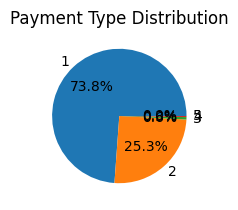

In [17]:
# Payment Type and Trip Type distribution
plt.subplot(2, 2, 1)
payment_counts = df['payment_type'].value_counts()
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%')
plt.title('Payment Type Distribution')


Text(0.5, 1.0, 'Trip Type Distribution')

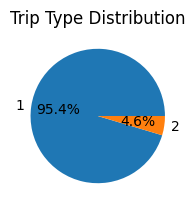

In [18]:
plt.subplot(2, 2, 2)
trip_counts = df['trip_type'].value_counts()
plt.pie(trip_counts, labels=trip_counts.index, autopct='%1.1f%%')
plt.title('Trip Type Distribution')

Text(0.5, 1.0, 'Trip Distance Distribution (capped at 20 miles)')

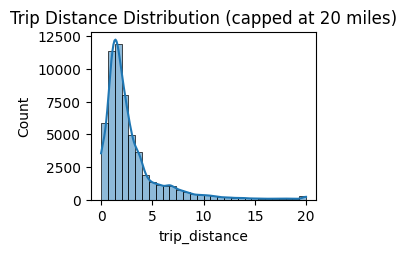

In [19]:
# Trip distance distribution
plt.subplot(2, 2, 3)
sns.histplot(df['trip_distance'].clip(upper=20), bins=30, kde=True)
plt.title('Trip Distance Distribution (capped at 20 miles)')

Text(0.5, 1.0, 'Trip Duration Distribution (capped at 60 minutes)')

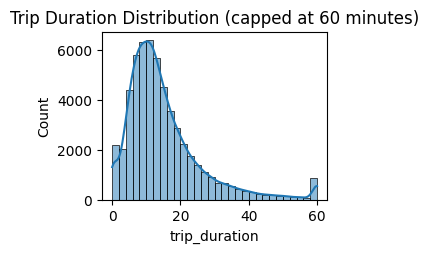

In [20]:
# Trip duration distribution
plt.subplot(2, 2, 4)
sns.histplot(df['trip_duration'].clip(upper=60), bins=30, kde=True)
plt.title('Trip Duration Distribution (capped at 60 minutes)')

In [21]:
plt.tight_layout()
plt.savefig('taxi_distribution_plots.png')
plt.close()

In [22]:
# Temporal analysis
# Average fare by hour and weekday
hourly_amounts = df.groupby('hourofday')['total_amount'].mean().reset_index()
weekday_amounts = df.groupby('weekday')['total_amount'].mean().reset_index()

In [23]:
# Create custom weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_amounts['weekday'] = pd.Categorical(weekday_amounts['weekday'], categories=weekday_order, ordered=True)
weekday_amounts = weekday_amounts.sort_values('weekday')

In [24]:
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'Average Total Amount ($)')

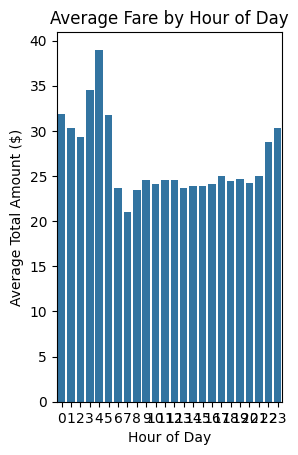

In [25]:
plt.subplot(1, 2, 1)
sns.barplot(x='hourofday', y='total_amount', data=hourly_amounts)
plt.title('Average Fare by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Amount ($)')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

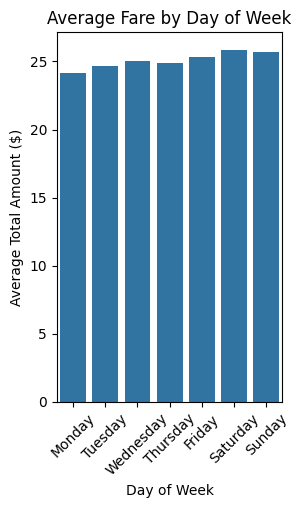

In [26]:
plt.subplot(1, 2, 2)
sns.barplot(x='weekday', y='total_amount', data=weekday_amounts)
plt.title('Average Fare by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Amount ($)')
plt.xticks(rotation=45)

In [27]:
plt.tight_layout()
plt.savefig('temporal_analysis.png')
plt.close()

In [28]:
# Tip analysis
# Create tip percentage feature
df['tip_percentage'] = (df['tip_amount'] / df['fare_amount']) * 100
df.loc[df['tip_percentage'].isin([np.inf, -np.inf]), 'tip_percentage'] = 0
df['tip_percentage'] = df['tip_percentage'].fillna(0).clip(upper=100)  # Cap at 100%

In [29]:
print("\nAverage tip percentage by payment type:")
print(df.groupby('payment_type')['tip_percentage'].mean().sort_values(ascending=False))


Average tip percentage by payment type:
payment_type
1    21.144000
3     0.371517
2     0.000000
5     0.000000
4    -0.155502
Name: tip_percentage, dtype: float64


In [30]:
print("\nAverage tip percentage by weekday:")
print(df.groupby('weekday')['tip_percentage'].mean().sort_values(ascending=False))


Average tip percentage by weekday:
weekday
Wednesday    15.852983
Tuesday      15.825497
Thursday     15.791088
Monday       15.785086
Sunday       15.528101
Friday       15.442490
Saturday     14.834013
Name: tip_percentage, dtype: float64


In [31]:
print("\nAverage tip percentage by hour of day:")
hour_tips = df.groupby('hourofday')['tip_percentage'].mean().reset_index()
print(hour_tips.sort_values('tip_percentage', ascending=False).head(5))


Average tip percentage by hour of day:
    hourofday  tip_percentage
19         19       17.772258
18         18       17.578988
17         17       17.377864
20         20       16.930372
21         21       16.904084


Text(0, 0.5, 'Average Tip (%)')

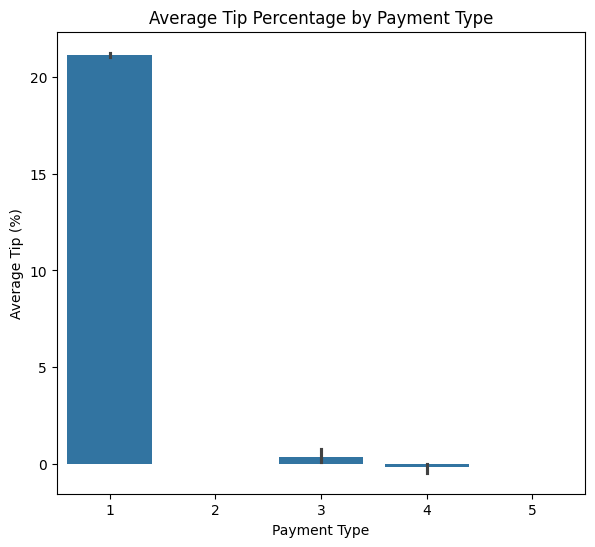

In [32]:
# Visualize tip patterns
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='payment_type', y='tip_percentage', data=df)
plt.title('Average Tip Percentage by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Tip (%)')


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Tuesday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

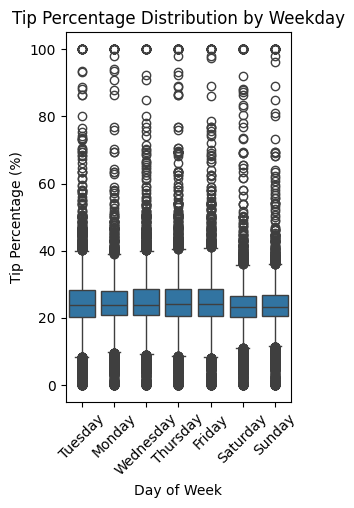

In [33]:
plt.subplot(1, 2, 2)
sns.boxplot(x='weekday', y='tip_percentage', data=df[df['tip_percentage'] > 0])
plt.title('Tip Percentage Distribution by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Tip Percentage (%)')
plt.xticks(rotation=45)

In [34]:
plt.tight_layout()
plt.savefig('tip_analysis.png')
plt.close()

In [35]:
# Statistical tests
# ANOVA test for total_amount by trip_type
print("\nANOVA test for total_amount by trip_type:")
model = ols('total_amount ~ C(trip_type)', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)


ANOVA test for total_amount by trip_type:
                    sum_sq       df            F  PR(>F)
C(trip_type)  1.825916e+06      1.0  5018.171304     0.0
Residual      2.042897e+07  56145.0          NaN     NaN


In [36]:
# ANOVA test for total_amount by weekday
print("\nANOVA test for total_amount by weekday:")
model = ols('total_amount ~ C(weekday)', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)


ANOVA test for total_amount by weekday:
                  sum_sq       df         F    PR(>F)
C(weekday)  1.502637e+04      6.0  6.321834  0.000001
Residual    2.223986e+07  56140.0       NaN       NaN


In [37]:
# Chi-square test for association between trip_type and payment_type
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-square test for association between trip_type and payment_type:")
print(f"Chi2: {chi2:.4f}, p-value: {p:.8f}")


Chi-square test for association between trip_type and payment_type:
Chi2: 212.3329, p-value: 0.00000000


In [38]:
# Correlation analysis
# Select numerical columns for correlation
correlation_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount',
                    'total_amount', 'passenger_count', 'weekend']

In [39]:
corr_matrix = df[correlation_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.close()

In [40]:
# Prepare data for modeling
# Create dummy variables
df_encoded = pd.get_dummies(df, columns=['store_and_fwd_flag', 'RatecodeID',
                                         'payment_type', 'trip_type',
                                         'weekday'], drop_first=True)

In [41]:
# Select features and target
X = df_encoded.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime',
                    'PULocationID', 'DOLocationID', 'total_amount',
                    'tip_percentage'], axis=1, errors='ignore')
y = df_encoded['total_amount']

In [42]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (44917, 31)
Test set: (11230, 31)


In [43]:
# Build and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

In [46]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2
    })

    print(f"{name}:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")
    print(f"  R² Score: {r2:.4f}")


Linear Regression:
  RMSE: $0.44
  MAE: $0.27
  R² Score: 0.9995
Decision Tree:
  RMSE: $1.53
  MAE: $0.80
  R² Score: 0.9938
Random Forest:
  RMSE: $1.11
  MAE: $0.21
  R² Score: 0.9968
Gradient Boosting:
  RMSE: $0.86
  MAE: $0.35
  R² Score: 0.9981


In [47]:
# Feature importance for best model (Random Forest)
best_model = models['Random Forest']
features = X.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]
# Get top 10 features

In [48]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Important Features for Predicting Fare Amount')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

In [49]:
# Additional analysis - trip distance vs. fare amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df.sample(1000), alpha=0.6, s=50)
plt.title('Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, alpha=0.3)
plt.savefig('distance_vs_fare.png')
plt.close()

In [50]:
# Create a summary DataFrame of model results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
            Model     RMSE      MAE  R² Score
Linear Regression 0.442399 0.268691  0.999484
    Decision Tree 1.531976 0.798301  0.993813
    Random Forest 1.109744 0.205560  0.996754
Gradient Boosting 0.858748 0.350106  0.998056


In [51]:
# Create a new visualization showing VendorID comparison
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'Trip Distance (miles)')

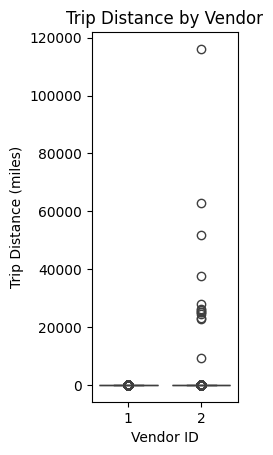

In [52]:
# Compare trip distance by vendor
plt.subplot(1, 3, 1)
sns.boxplot(x='VendorID', y='trip_distance', data=df)
plt.title('Trip Distance by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Trip Distance (miles)')

Text(0, 0.5, 'Fare Amount ($)')

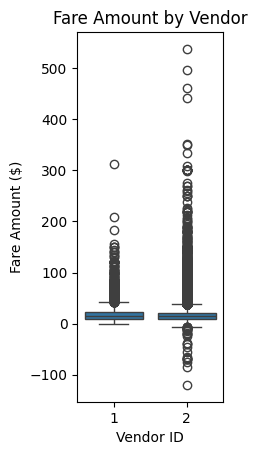

In [53]:
# Compare fare by vendor
plt.subplot(1, 3, 2)
sns.boxplot(x='VendorID', y='fare_amount', data=df)
plt.title('Fare Amount by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Fare Amount ($)')

Text(0, 0.5, 'Tip Percentage (%)')

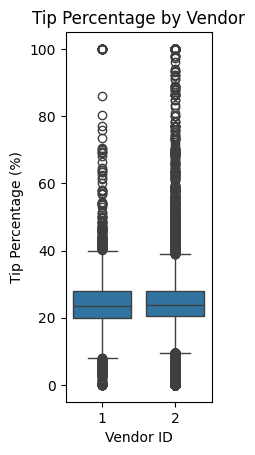

In [54]:
# Compare tip by vendor
plt.subplot(1, 3, 3)
sns.boxplot(x='VendorID', y='tip_percentage', data=df[df['tip_percentage'] > 0])
plt.title('Tip Percentage by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Tip Percentage (%)')

In [55]:
plt.tight_layout()
plt.savefig('vendor_comparison.png')
plt.close()

In [56]:
# Add map visualization - location-based analysis (mock visualization as we don't have actual location data)
# This would typically use actual location data, but we're creating a mock visualization
plt.figure(figsize=(10, 8))
unique_locations = df['PULocationID'].unique()
location_counts = df['PULocationID'].value_counts().sort_index()

<Figure size 1000x800 with 0 Axes>

In [58]:
plt.bar(range(len(location_counts)), location_counts.values)
plt.title('Trip Count by Pickup Location ID')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks([])  # Hide x-axis ticks as there would be too many
plt.savefig('location_analysis.png')
plt.close()

print("\nAnalysis complete (October 2024 by Ruthvik Akula - Sap id : 70572200028 !")


Analysis complete (October 2024 by Ruthvik Akula - Sap id : 70572200028 !
